In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Exercises
This must be marked before you leave the lab. Mark weighting is in brackets.
**Save your work to GitHub after having run all cells with `Runtime` -> `Restart and run all`. And do not change the notebook's filename.** Do add comments to your code, you'll lose points if your code is hard to understand. Graphs without labels (or units when appropriate) are not worth any point.

**Note**: "fitting" does include providing the error measurements. E.g. the answer is not $a=100$ but $a=100^+_-1$.

## Exercise 0

[0] See the video on LearningCentral about fitting a Power Law to the Black Holes mass distribution.

## Exercise 1
[2] Use the above ideas to repeat a _linear_ fit using the `curve_fit` routine (not a _quadratic_ as in the example in the introduction). Confirm, by using your linfit function, that you get the same result as before.

curve_fit results:
m: 99.05952380952381+/-0.9295124745702205
c: 6.166666666666666+/-3.888429392602639

linfit results:
m: 99.06+/-6.167
c: 0.93+/-3.888


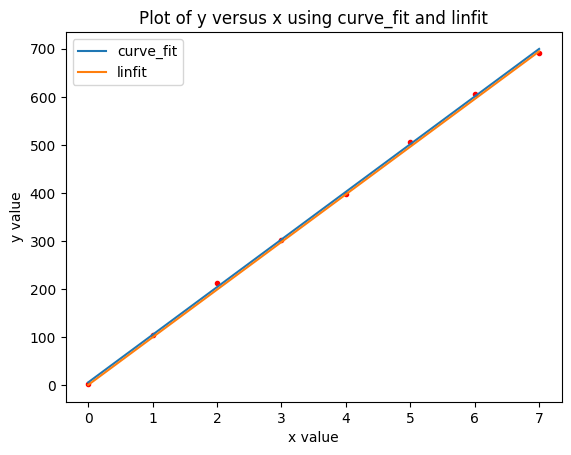

In [200]:
import utilities

def linear(x, *p):
  '''
  defines a linear function with parameters p[0] and p[1]
  '''
  return p[0]*x + p[1]

# defning the x and y test data for the example
x_data = np.array([ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0 ])
y_data = np.array([ 2, 104, 212, 302, 398, 507, 606, 692 ])
# plotting the data points
plt.plot(x_data, y_data, 'r.')

# initial guess parameters, not important for the example
p_guess = [100,2]

popt, pcov = curve_fit(linear, x_data, y_data, p_guess)

# plotting curve fit fitting
x_plot = np.linspace(min(x_data),max(x_data),num=100)
plt.plot(x_plot, linear(x_plot, *popt), label="curve_fit")
# showing the numerical values for the curve_fit line
print (f'curve_fit results:\nm: {popt[0]}+/-{np.sqrt(pcov.diagonal()[0])}\nc: {popt[1]}+/-{np.sqrt(pcov.diagonal()[1])}')

# plotting linfit fitting from past weeks
*p_lin, dm, dc = utilities.linfit(x_data, y_data)
plt.plot(x_plot, linear(x_plot, *p_lin), label='linfit')
# showing the numerical values for the linfit line
print(f'\nlinfit results:\nm: {p_lin[0]}+/-{dm}\nc: {p_lin[1]}+/-{dc}')

plt.xlabel('x value')
plt.ylabel('y value')
plt.title('Plot of y versus x using curve_fit and linfit')
plt.legend()

plt.savefig('curve_fitVSlinfit.png')

## Exercise 2
The data file `XRD_data_Mo_anode.csv`:

contains X-ray diffraction data from a molybdenum anode source, obtained using a NaCl crystal. It shows two features, the K-alpha and K-beta (in the data one can see 3 orders – the 4th is present but weak) on top of a Brehmstrahlung (braking radiation) background. The columns are angle in degrees and intensity (measured as counts per second).

1) [3] Read in the raw data points and plot a graph. Estimate **by eye** and make a note of the rough positions, widths and intensitys of the **first** two **main** peaks in first order (highest peaks), around angles of 6 and 7 degrees. Create a single data array that include the angle and count values from around those two peaks. For instance, to only have the data between angle of 1 and 30 you could do:

    ```python
    angles_selected=angles_full_data[(angles_full_datat>=1) & (angles_full_data<=30)]
    counts_selected=counts_full_data[(angles_full_datat>=1) & (angles_full_data<=30)]
    ```
    
    (1 and 30 are not the right values, you need to look at the plot, and make surer you include all of both peaks, but minimise any other features such as higher order peaks or drop-offs).

2) [2] The peaks can be approximated as Gaussian in shape, i.e.: $$G(x;I,\mu,\sigma)=I\frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right)$$ Define (in a similar way you did for the linear fitting) a Gaussian function, which you will use for fitting the data:

    ```python
    Gau(x, intensity, mu, sigma)
    ```

    Note that this Gaussian is normalised to have an area under the curve of intensity (I).

3) [2] Now use `curve_fit()` to try fitting a Gaussian to the highest peak in the data you selected containing those first two peaks near 6 and 7. and plot the result. Remember to first plot your guess !

4) [3] Repeat, but allowing for a constant background offset to improve the fit. Hint: Do this by defining a fitting function comprising a constant term plus a Gaussian, say `Gau_background(x, intensity, mu, sigma, bckg)`. (You can call the `Gau()` function from within `Gau_background()`. You now have four fitting parameters instead of three.)  
  
5) [4] Repeat, but allowing for a linear background to improve the fit. (This requires a function with an extra fitting parameter.)

6) [4] Repeat, but allowing not only for a linear background to improve the fit, but also trying to fit the other peak together with the main one.

Notes:

  - Always plot your fitting function with some guesses first.
  - If the error on all the parameters is very large, in general it means `curve_fit()` did not really manage to fit anything, don't use those values.
  - Remember parameters are (by default) unbounded floats, e.g. if you try to fit a Gaussian at ~6.8, `curve_fit()` will hapilly try a negative intensity, e.g. fit a dip instead of a peak.
  - When using bounds, careful with railing ! If the errors or values are equal (or nearly equal) to the bounds, the fit is not reliable and depends on the provided bounds.
  - When fitting both signal and background, you can also try subtracting the background fit to the data.


In [201]:
! wget -q https://raw.githubusercontent.com/PX2134/data/master/week4/XRD_data_Mo_anode.csv

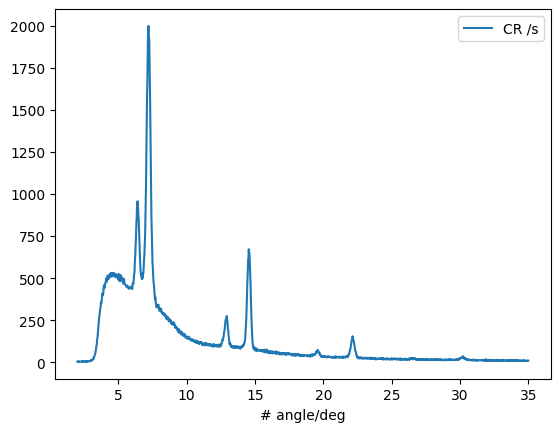

In [202]:
# 1
# reading the data and plotting it from the headers
raw_data = pd.read_csv('XRD_data_Mo_anode.csv', header=1)
raw_data.plot(x='# angle/deg', y='CR /s')

#  By eye, first peak roughly 6.1-6.7 degrees peaking at 1000 /s, and second peak roughly 6.7-7.7 peaking at 2000 /s

# get only the selected angles and count-rates from the list of all angles between 6.1 & 7.7
all_angles = raw_data.loc[:,'# angle/deg']
angles_selected = all_angles[(all_angles>=6.1) & (all_angles<=7.7)]
counts_selected = raw_data.loc[:,'CR /s'][(all_angles>=6.1) & (all_angles<=7.7)]

# highest peak: 6.7-7.7
peak_angles = angles_selected[(angles_selected>=6.7) & (angles_selected<=7.7)]
peak_counts = counts_selected[(angles_selected>=6.7) & (angles_selected<=7.7)]

In [203]:
# 2

def gau(x, intensity, mu, sigma):
  '''
  defines a Gaussian function with parameters intensity, mu and sigma, and the x data
  returns the Gaussian function at the x values, using the formula shown above
  '''
  return intensity / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

I: 975.9233785421953 +/- 28.161990468364213
mu: 7.201245551349321 +/- 0.007230309629693723
sigma: 0.21927568726331823 +/- 0.00745072358358711


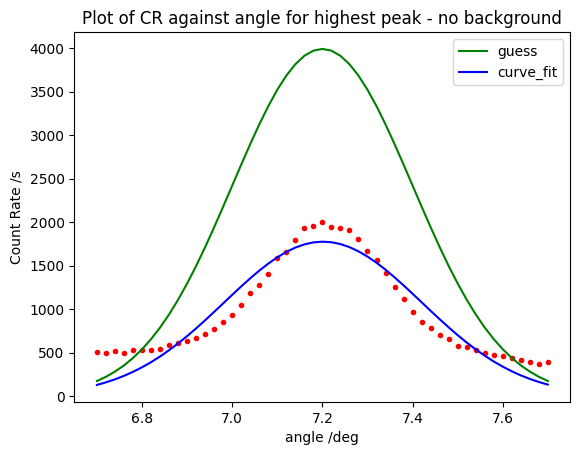

In [204]:
# 3

# highest peak
# guess parameters: peaks at 2000, rough width 1, so I=2000, sigma ~ 0.2, mu ~ halfway 6.7-7.7 ~ 7.2
p_guess=[2000, 7.2, 0.2]

# plotting data points and initial guess
plt.plot(peak_angles, peak_counts, 'r.')
plt.plot(peak_angles, gau(peak_angles, *p_guess), 'g-', label='guess')

popt, pcov = curve_fit(gau, peak_angles, peak_counts, p_guess)
# checking values and errors
print(f'I: {popt[0]} +/- {np.sqrt(pcov.diagonal())[0]}\nmu: {popt[1]} +/- {np.sqrt(pcov.diagonal())[1]}\nsigma: {popt[2]} +/- {np.sqrt(pcov.diagonal())[2]}')
# all reasonable, so values usable

# plotting curve_fit
plt.plot(peak_angles, gau(peak_angles, *popt), 'b-', label='curve_fit')

plt.xlabel('angle /deg')
plt.ylabel('Count Rate /s')
plt.title('Plot of CR against angle for highest peak - no background')
plt.legend()

I: 512.3874431458783 +/- 8.608707955967231
mu: 7.206099067707931 +/- 0.001432049322483782
sigma: 0.13444733421188731 +/- 0.00190407050796676
bckg: 468.18906624403974 +/- 10.081222409647623


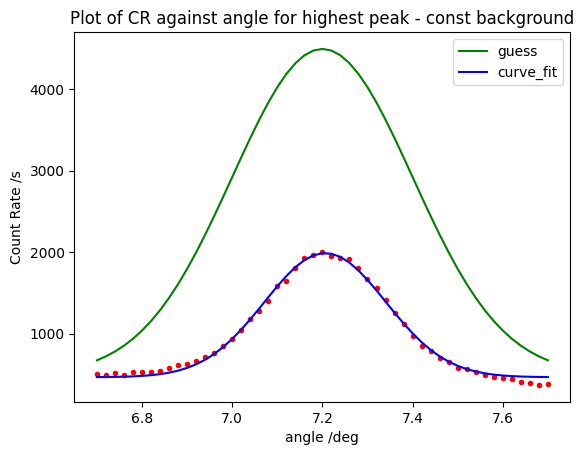

In [205]:
# 4

def gau_bckg(x, intensity, mu, sigma, bckg):
  '''
  defines a Gaussian function with parameters intensity, mu and sigma, and background data
  returns a Gaussian curve that has a constant background
  '''
  return gau(x, intensity, mu, sigma) + bckg


# guess parameters remain same, plus background of ~ 500 /s
p_guess=[2000, 7.2, 0.2, 500]

# plotting data points and initial guess
plt.plot(peak_angles, peak_counts, 'r.')
plt.plot(peak_angles, gau_bckg(peak_angles, *p_guess), 'g-', label='guess')

popt, pcov = curve_fit(gau_bckg, peak_angles, peak_counts, p_guess)
# checking values and errors
print(f'I: {popt[0]} +/- {np.sqrt(pcov.diagonal())[0]}\nmu: {popt[1]} +/- {np.sqrt(pcov.diagonal())[1]}\nsigma: {popt[2]} +/- {np.sqrt(pcov.diagonal())[2]}\nbckg: {popt[3]} +/- {np.sqrt(pcov.diagonal())[3]}')
# all reasonable, so values usable

# plotting curve_fit
plt.plot(peak_angles, gau_bckg(peak_angles, *popt), 'b-', label='curve_fit')

plt.xlabel('angle /deg')
plt.ylabel('Count Rate /s')
plt.title('Plot of CR against angle for highest peak - const background')
plt.legend()

I: 513.9000198937204 +/- 4.822602769929958
mu: 7.210114651326351 +/- 0.0008901097477644778
sigma: 0.13462836207438886 +/- 0.00106365157603614
bckg_gradient: -119.82309493430053 +/- 11.71234512326519
bckg_intercept: 1329.4362947108918 +/- 84.24900240018063


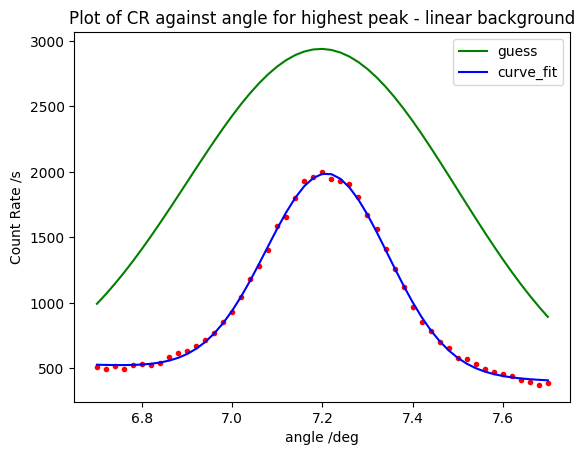

In [206]:
# 5
#redefining gau_bckg for a linear background
def gau_bckg(x, intensity, mu, sigma, bckg_m, bckg_c):
  '''
  defines a Gaussian function with parameters intensity, mu and sigma, and linear background data
  returns a Gaussian curve that has a linear background
  '''
  return gau(x, intensity, mu, sigma) + bckg_m*x + bckg_c

# guess parameters remain same, plus background of ~ (1000 - 100 x) /s
p_guess=[2000, 7.2, 0.3, -100, 1000]

# plotting data points and initial guess
plt.plot(peak_angles, peak_counts, 'r.')
plt.plot(peak_angles, gau_bckg(peak_angles, *p_guess), 'g-', label='guess')

popt, pcov = curve_fit(gau_bckg, peak_angles, peak_counts, p_guess)
# checking values and errors
print(f'I: {popt[0]} +/- {np.sqrt(pcov.diagonal())[0]}\nmu: {popt[1]} +/- {np.sqrt(pcov.diagonal())[1]}\nsigma: {popt[2]} +/- {np.sqrt(pcov.diagonal())[2]}')
print(f'bckg_gradient: {popt[3]} +/- {np.sqrt(pcov.diagonal())[3]}\nbckg_intercept: {popt[4]} +/- {np.sqrt(pcov.diagonal())[4]}')
# all reasonable, so values usable

# plotting curve_fit
plt.plot(peak_angles, gau_bckg(peak_angles, *popt), 'b-', label='curve_fit')

plt.xlabel('angle /deg')
plt.ylabel('Count Rate /s')
plt.title('Plot of CR against angle for highest peak - linear background')
plt.legend()

I_1: 116.35425149983168 +/- 5.441049068184738
mu_1: 6.408942070685477 +/- 0.002837286781306338
sigma_1: 0.10492219728389056 +/- 0.003928192780002515
I_2: 521.797722916424 +/- 5.416461341390382
mu_2: 7.208308851699144 +/- 0.0009691591533916314
sigma_2: 0.13604857860906433 +/- 0.0011955454417014225
bckg_gradient: -67.14684594610296 +/- 10.053992183823258
bckg_intercept: 938.8798802960654 +/- 70.91144471831122


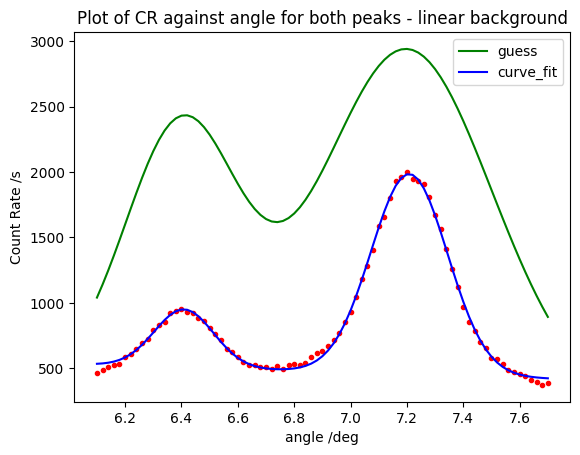

In [207]:
# 6

def twin_gau(x, intensity_1, mu_1, sigma_1, intensity_2, mu_2, sigma_2, bckg_m, bckg_c):
  '''
  defines a Gaussian function with parameters intensity, mu and sigma for two peaks and background data
  returns two Gaussian curves that have a linear background
  '''
  return gau(x, intensity_1, mu_1, sigma_1) + gau(x, intensity_2, mu_2, sigma_2) + bckg_m*x + bckg_c

# guess parameters by eye
p_guess=[1000, 6.4, 0.2, 2000, 7.2, 0.3, -100, 1000]

# plotting data points and initial guess
plt.plot(angles_selected, counts_selected, 'r.')
plt.plot(angles_selected, twin_gau(angles_selected, *p_guess), 'g-', label='guess')

popt, pcov = curve_fit(twin_gau, angles_selected, counts_selected, p_guess)
# checking values and errors
print(f'I_1: {popt[0]} +/- {np.sqrt(pcov.diagonal())[0]}\nmu_1: {popt[1]} +/- {np.sqrt(pcov.diagonal())[1]}\nsigma_1: {popt[2]} +/- {np.sqrt(pcov.diagonal())[2]}')
print(f'I_2: {popt[3]} +/- {np.sqrt(pcov.diagonal())[3]}\nmu_2: {popt[4]} +/- {np.sqrt(pcov.diagonal())[4]}\nsigma_2: {popt[5]} +/- {np.sqrt(pcov.diagonal())[5]}')
print(f'bckg_gradient: {popt[6]} +/- {np.sqrt(pcov.diagonal())[6]}\nbckg_intercept: {popt[7]} +/- {np.sqrt(pcov.diagonal())[7]}')
#all reasonable, so values usable

# plotting curve_fit
plt.plot(angles_selected, twin_gau(angles_selected, *popt), 'b-', label='curve_fit')

plt.xlabel('angle /deg')
plt.ylabel('Count Rate /s')
plt.title('Plot of CR against angle for both peaks - linear background')
plt.legend()